### Use ENGIE’s open data set

ENGIE provides access to the data of its 'La Haute Borne' wind farm through https://opendata-renewables.engie.com and through an API. The data can be used to create additional turbine objects and gives users the opportunity to work with further real-world data. In the following example, data is loaded into a turbine object and plotted as a power curve. The selected turbine, as well as the start and end date, can be changed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from operational_analysis.toolkits import filters
from operational_analysis.toolkits import power_curve
from engie_project import TurbineEngieOpenData

def plot_flagged_pc(ws, p, flag_bool, alpha):
    plt.scatter(ws, p, s = 1, alpha = alpha)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 1, c = 'red')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (kW)')
    plt.show()

In [2]:
engie = TurbineEngieOpenData(name = 'R80711',start_date = "01.01.2017 00:00",end_date = "03.01.2017 00:00")
engie.prepare()
engie.scada.df.sort_index(inplace=True)

display(engie.scada.head())

,ba_avg,ba_max,ba_min,ba_std,cm_avg,cm_max,cm_min,cm_std,cosphi_avg,cosphi_max,...,ya_min,ya_std,yt_avg,yt_max,yt_min,yt_std,time,power_kw,winddirection_deg,windspeed_ms
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-0.99,-0.99,-0.99,0.0,1460.6700,1763.3600,1142.8101,197.600010,0.99,0.98,...,209.63000,0.00,16.680000,17.100000,16.299999,0.24,2017-01-01 00:00:00,143.06000,195.17000,5.36
2017-01-01 00:10:00,-0.99,-0.99,-0.99,0.0,2080.8201,2553.8999,1750.5200,207.750000,1.00,1.00,...,187.67999,10.71,17.570000,18.200001,17.100000,0.36,2017-01-01 00:10:00,262.19000,180.41000,5.91
2017-01-01 00:20:00,-0.99,-0.99,-0.99,0.0,2653.1201,2937.9700,2265.0100,167.570010,1.00,1.00,...,187.67999,8.07,18.719999,18.900000,18.200001,0.22,2017-01-01 00:20:00,393.03000,208.12000,6.19
2017-01-01 00:30:00,-0.99,-0.99,-0.99,0.0,2728.2400,2976.9900,2576.7800,79.440002,1.00,1.00,...,204.14999,0.00,19.240000,19.700001,18.900000,0.24,2017-01-01 00:30:00,410.57001,198.47000,5.94
2017-01-01 00:40:00,-0.99,-0.99,-0.99,0.0,2956.0801,3150.6399,2778.5601,103.140000,1.00,1.00,...,204.14999,0.00,20.370001,20.900000,19.700001,0.30,2017-01-01 00:40:00,468.63000,197.74001,6.35


The data set includes many more sensor values in addition to time, power_kw, winddirection_deg, and windspeed_ms. The latter are renamed to match OpenOA's naming conventions. Let's plot the data.

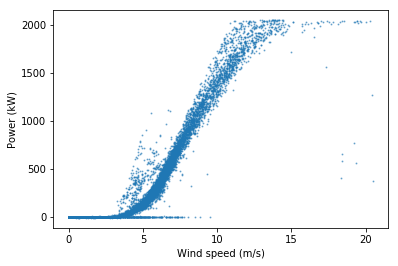

In [3]:
plot_flagged_pc(engie.scada.df["windspeed_ms"], engie.scada.df["power_kw"], np.repeat('True', engie.scada.df.shape[0]), 0.5)

In the next steps, we apply all filters following the previous example. In addition, we make sure to delete all Null values beforehand.

In [4]:
# Basic filtering for NaNs
df = engie.scada.df
df = df[df["windspeed_ms"].notnull()]
df = df[df["power_kw"].notnull()]
# Assign data 
windspeed = df["windspeed_ms"]
power_kw =  df["power_kw"]
# Remove outliers
out_of_range = filters.range_flag(windspeed, below=0.01, above=70)
windspeed = windspeed[~out_of_range]
power_kw = power_kw[~out_of_range]
# Window Range Filter
out_of_window = filters.window_range_flag(windspeed, 6., 40, power_kw, 20., 2500.)
windspeed = windspeed[~out_of_window]
power_kw = power_kw[~out_of_window]
# Bin Filter
max_bin = 0.90*power_kw.max()
bin_outliers = filters.bin_filter(power_kw, windspeed, 100, 1.5, 'median', 20., max_bin, 'scalar', 'all')
windspeed = windspeed[~bin_outliers]
power_kw = power_kw[~bin_outliers]
# Unresponsive Filter
frozen = filters.unresponsive_flag(windspeed, 3)
windspeed = windspeed[~frozen]
power_kw = power_kw[~frozen]

The result is a cleaner data set.

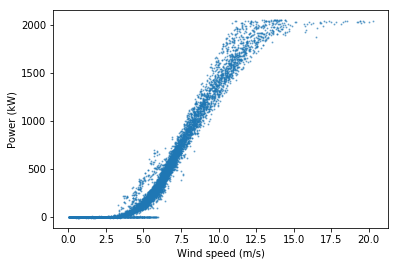

In [5]:
plot_flagged_pc(windspeed, power_kw, np.repeat('True', len(windspeed)), 0.5)

In [6]:
# Fit the power curves
iec_curve = power_curve.IEC(windspeed, power_kw)
l5p_curve = power_curve.logistic_5_parametric(windspeed, power_kw)
spline_curve = power_curve.gam(windspeed, power_kw, n_splines = 20)

/Users/jperrsau/src/pruf/openoa-public/OpenOA/operational_analysis/toolkits/power_curve/parametric_forms.py:35: RuntimeWarning: divide by zero encountered in power
  return d + (a - d) / (1 + (x / c) ** b) ** g


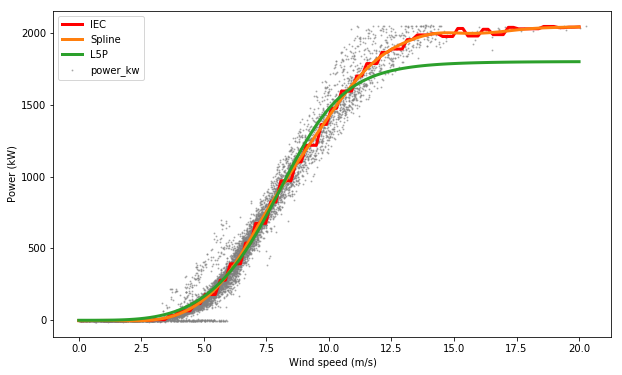

In [7]:
# Plot the results
x = np.linspace(0,20,100)
plt.figure(figsize = (10,6))
plt.scatter(windspeed, power_kw, alpha=0.5, s = 1, c = 'gray')
plt.plot(x, iec_curve(x), color="red", label = 'IEC', linewidth = 3)
plt.plot(x, spline_curve(x), color="C1", label = 'Spline', linewidth = 3)
plt.plot(x, l5p_curve(x), color="C2", label = 'L5P', linewidth = 3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()